In [1]:
import json
import numpy as np



In [2]:
root_dir = 'all_annotations/dekra_annotations/'
annotations_dir = f'{root_dir}/annotations/instances_default.json'
image_dir = f'{root_dir}/images'


## Keys to include

In [3]:
all_keys = ["anlagenummer","prüfgrundlage","objectstandort", "objectkart_anlage", "Fabrik_nr", "eigennummer", "eigenname", "arbeitgeber", "verwendete_messegeräte",
"baujahr",
"wartungsfirma",
"tragfähigkeit",
"errichtungsgrundlage",
"haltstellen_zugangstellen",
"geschwindigkeit",
"antrieb_aufhängung",
"förderhöhe",
"ergebnis_der_prüfung",
"betreiber",
"Prüfsystem",
"nächste_prüfung",
"datum_der_prüfung",
"Liegenschaft",
"Straße",
"Stadt",
"vertragsnummer",
"serviceorder",
"objektangabe",
"leistungsdatum",
"anlagentyp",
"durchgeführt_von",
"plz",
"technikers_mängelanzeige",
"equipment_nummer",
"aufstrags_nummer",
"kunden_nummer",
"akten_nummer",
"leistungsort",
"leistungsempfänger",
"inventar_nr",
"prüfort",
"standort",
"hertsteller",
"ausführende_firma",
"betriebsteil",
"kostenst_betreiber",
"standort_b_kunden"]

keys_needed = ["anlagenummer","objectstandort", "Fabrik_nr", "eigennummer", "eigenname", "arbeitgeber",
"baujahr",
"wartungsfirma",
"tragfähigkeit",
"haltstellen_zugangstellen",
"geschwindigkeit",
"förderhöhe",
"ergebnis_der_prüfung",
"betreiber",
"nächste_prüfung",
"datum_der_prüfung",
"Straße",
"Stadt",
"vertragsnummer",
"leistungsdatum",
"durchgeführt_von",
"plz",
"technikers_mängelanzeige",
"equipment_nummer",
"aufstrags_nummer",
"kunden_nummer",
"akten_nummer",
"leistungsort",
"inventar_nr",
"prüfort",
"standort",
"hertsteller",
"ausführende_firma"]

In [ ]:
print(keys_needed)

In [ ]:

#with open(annotations_dir) as f:
#        configs = json.load(f)
        
#print(configs.keys())

In [ ]:
#configs['categories']

In [4]:
from utility_functions.utilities_kie import * 
#tokenizer = AutoTokenizer.from_pretrained("microsoft/layoutxlm-base")
#model = AutoModel.from_pretrained("microsoft/layoutxlm-base")

tokenizer = AutoTokenizer.from_pretrained("tokenizer_added_tokens")
model = AutoModel.from_pretrained("model_added_tokens")

Some weights of the model checkpoint at model_added_tokens were not used when initializing LayoutLMv2Model: ['extractor.rel_classifier.linear.bias', 'extractor.entity_emb.weight', 'extractor.ffnn_tail.3.weight', 'extractor.ffnn_tail.0.weight', 'extractor.ffnn_tail.0.bias', 'extractor.ffnn_tail.3.bias', 'extractor.rel_classifier.bilinear.weight', 'extractor.ffnn_head.3.bias', 'extractor.ffnn_head.0.weight', 'extractor.ffnn_head.3.weight', 'extractor.ffnn_head.0.bias', 'extractor.rel_classifier.linear.weight']
- This IS expected if you are initializing LayoutLMv2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMv2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
import pickle

def preprocess_tokens(tokens:list=None, bboxes:list=None):
    speical_characters = set(string.punctuation)
    tokens_preprocessed = []
    bboxes_preprocessed = []
        
    for i, token in enumerate(tokens):
        token = token.lower()
        for char_ in speical_characters:
            token = token.strip(char_)
        if token not in speical_characters and token not in (' ',  '', '\t','\n') and len(token) > 0:
            tokens_preprocessed.append(token)
            bboxes_preprocessed.append(bboxes[i])
        
    return tokens_preprocessed, bboxes_preprocessed

def load_annotation_image(image_id:int=None, configs:dict=None):
    annotations = []
    for annotation in configs["annotations"]:
        if annotation["image_id"] == image_id:
            annotations.append(annotation)
    return annotations
        
def load_category(category_id:int=None, configs:dict=None):
    for category in configs["categories"]:
        if category["id"] == category_id:
            return category
                    


def postprocess_bobx(bbox, image_dim):
    bbox_postprocessed = []
    
    #for i in bbox:
    #    if i - float(int(i)) < 0.5:
    #        val = int(np.floor(i))
    #        bbox_postprocessed.append(val)
    #    else:
    #        val = int(np.ceil(i))
    #        bbox_postprocessed.append(val)
    bbox_postprocessed = [bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]]
    
    bbox_postprocessed = normalize_bbox(bbox_postprocessed, width=image_dim['width'], height = image_dim['height'])
    
    return bbox_postprocessed


def split_text_bboxes(bbox, text, category):
    #print(text)
    tokens = text.split(' ')
    bboxes = [bbox for _ in range(len(tokens))]
    tokens, bboxes = preprocess_tokens(tokens=tokens, bboxes=bboxes)
    categories = [category for _ in range(len(tokens))]
    return tokens, bboxes, categories

def form_entities(token_cat_groups, tokenizer, input_ids, input_id_map):
    entities = {'start':[], 'end':[], 'label':[], 'cat':[]}
    label_vals_simplified = {"OTHER": 0, "QUESTION" : 1, "ANSWER" : 2}
    #print(token_cat_groups)
    for token_cat_group in token_cat_groups:
        token_group = token_cat_group[0]
        cat_group = token_cat_group[1]
        
        if len(cat_group) >0 and len(token_group) >0:
            cat = cat_group[0]
        
            input_ids_token_group = [input_id_map[tokenized_token] for token in token_group for tokenized_token in tokenizer.tokenize(token) if tokenized_token in input_id_map.keys()]
            indexes = find_sequnce_indices(sequence=input_ids_token_group, input_ids=input_ids)
        
            start_idx = indexes[0][0]
            end_idx = indexes[0][-1]
        
            entities['start'].append(start_idx)  
            entities['end'] .append(end_idx)
            if '_key' in cat:
                entities['label'].append(label_vals_simplified['QUESTION'])
            elif '_value' in cat:
                entities['label'].append(label_vals_simplified['ANSWER'])
            else:
                entities['label'].append(label_vals_simplified['OTHER'])
            entities['cat'].append(cat)
    return entities
    
        
        
           

def label_tokens(annotation, category, bbox):
    label_vals = {'O' : 0, 'B-QUESTION' : 1, 'B-ANSWER' : 2, 'B-HEADER' : 3, 'I-ANSWER' : 4, 'I-QUESTION' : 5, 'I-HEADER' : 6}
    
    annotation_attributes = annotation['attributes']
    #bbox = postprocess_bobx(annotation['bbox'])
    text = annotation_attributes['content']
    tokens, _, _ = split_text_bboxes(bbox, text, category)
    labels = []
    #category_temp = category[:category.rfind('_')]
    for i in range(len(tokens)):
        if i==0:
            #if category_temp in keys_needed:
                #print(f'keys needed {category_temp}')
            if 'key' in category:
                labels.append(label_vals['B-QUESTION'])
            elif 'value' in category:
                labels.append(label_vals['B-ANSWER'])
            else:
                #print(f'keys not needed {category_temp}')
                #print('---')
                labels.append(label_vals['O'])
        else:
            #if category_temp in keys_needed:
            #    print(f'keys needed {category_temp}')
            if 'key' in category:
                labels.append(label_vals['I-QUESTION'])
            elif 'value' in category :
                labels.append(label_vals['I-ANSWER'])
            else:
                #print(f'keys not needed {category_temp}')
                #print('---')
                labels.append(label_vals['O'])
        
    return labels

def label_input_ids(tokens, bboxes, tokenizer, labels_tokens):

    labels = []
    for i,token in enumerate(tokens):
        #print(bboxes[1])
        input_ids, _, _ = encode_tokens(tokens=[token], bboxes=[bboxes[i]], tokenizer=tokenizer)
        token_label = labels_tokens[i]
        labels_tokens_local = [token_label for _ in range(len(input_ids))]
        labels.extend(labels_tokens_local)
    
    return labels
        
        
    

def form_relations(entities, input_ids):
    entity_names_cat = {'entity_names':[], 'cat':[]}
    relations={'head':[], 'tail':[]}
    for i , (start, end) in enumerate(zip(entities['start'], entities['end'])):
        #print(f'{i}, {tokenizer.decode(input_ids[start:end])} : {entities["label"][i]} {entities["cat"][i]}')
        #if entities["label"][i].lower() != 'other':
        entity_names_cat['entity_names'].append(tokenizer.decode(input_ids[start:end]))
        entity_names_cat['cat'].append(entities['cat'][i])
 
    for i, entity in enumerate(entity_names_cat['entity_names']):
        cat = entity_names_cat['cat'][i]
        if '_key' in cat.lower():         
            j = entity_names_cat['cat'].index(f'{cat[:-4:]}_value') if f'{cat[:-4:]}_value' in entity_names_cat['cat'] else None
            if j is not None:
                head = i
                tail = j
                relations['head'].append(head)
                relations['tail'].append(tail)
            
                
            
        
    return entity_names_cat, relations
        
def dump_pickle(file_name:str=None, collection:object=None):
        file_name = os.path.join(os.getcwd(), file_name)
        with open(file_name, 'wb') as f:
            pickle.dump(collection, f)
            
def combine_annotations(image_id:int =None, configs=None, tokenizer=None, model =None, image_dim:dict=None):
    annotations = load_annotation_image(image_id=image_id, configs=configs)
    filtered_annotations = {'image_id':image_id, 'bboxes_tokens':[], 'bboxes':[], 'categories':[], 'text':[], 'labels' :[], 'input_ids':[], 'entities':[], 'relations':[], 'input_id_map':{}, 'token_cat_groups':[]}
    for annotation in annotations:
        bbox = postprocess_bobx(annotation['bbox'], image_dim)
        category = load_category(category_id=annotation['category_id'], configs=configs)["name"]
        #category = category if category in keys_needed else 'Others'
        
        annotation_attributes = annotation['attributes']
        if 'type' in annotation_attributes.keys() and category in keys_needed:
            type = annotation_attributes['type']
            filtered_annotations['categories'].append(f'{category}_{type}')
            category = f'{category}_{type}'

        
        text = annotation_attributes['content']
        tokens, bboxes, categories = split_text_bboxes(bbox, text, category)
        token_cat_group = (tokens, categories)
        filtered_annotations['token_cat_groups'].append(token_cat_group)
        labels = label_tokens(annotation, category, bbox)
        filtered_annotations['bboxes_tokens'].extend(bboxes)
        filtered_annotations['text'].extend(tokens)
        filtered_annotations['categories'].extend(categories)
        filtered_annotations['labels'].extend(labels)
    
    tokens, bbox = preprocess_tokens(tokens=filtered_annotations['text'], bboxes=filtered_annotations['bboxes_tokens'])
    tokenizer, model = add_tokens_tokenizer(tokens = tokens, tokenizer = tokenizer, model = model)
    input_ids, bboxes, input_id_map = encode_tokens(tokens=tokens, bboxes=bbox, tokenizer=tokenizer)
    filtered_annotations['bboxes'] = bboxes
    labels = label_input_ids(tokens, filtered_annotations['bboxes_tokens'], tokenizer, filtered_annotations['labels'])
    filtered_annotations['labels'] = labels
    filtered_annotations['labels']
    filtered_annotations['input_id_map'] = input_id_map
    filtered_annotations['input_ids'].extend(input_ids)
    
    
    #print(input_ids)
    #print(input_id_map)
    
        
    return filtered_annotations

        

In [6]:
images_dir = "images"
images_resized_dir = "images_resized"
bbox_dir="bbox"
input_ids_dir = "input_ids"
labels_dir = "labels"
entities_dir = "entities"
relations_dir = "relations"

## Impl 2 dataset generation funsd

In [7]:
from tqdm import tqdm
import random
import shutil

def create_directory_structure(dataset_dir:str, sub_dir:list, overwrite:bool):
    if overwrite and os.path.exists(dataset_dir):
        shutil.rmtree(dataset_dir)
        
    os.mkdir(dataset_dir)
    
    sub_dirs=['train', 'validation']
    for sub_dir in sub_dirs:
        inner_dir =f'{dataset_dir}/{sub_dir}' 
        os.mkdir(inner_dir)
        os.mkdir(f'{inner_dir}/{images_dir}')
        os.mkdir(f'{inner_dir}/{images_resized_dir}')
        os.mkdir(f'{inner_dir}/{bbox_dir}')
        os.mkdir(f'{inner_dir}/{labels_dir}')
        os.mkdir(f'{inner_dir}/{entities_dir}')
        os.mkdir(f'{inner_dir}/{relations_dir}')
        os.mkdir(f'{inner_dir}/{input_ids_dir}')

def get_file_index_map(path:str=None):
        paths = os.listdir(path)
        sorted_paths = sorted(paths, key=lambda x: int(x[x.rindex("_")+1:x.rindex(".")]))
        print(sorted_paths)
        idx_map = {sorted_path[sorted_path.rindex("_")+1:sorted_path.rindex(".")]:sorted_path for sorted_path in sorted_paths}
        #idx_map = {i:paths[i] for i in range(len(paths))}
        return idx_map

def load_dataset_funsd(annotations_configs:dict=None, image_dirs:dict=None, dataset_dir:str= 'dataset_real', tokenizer=None, model=None, train_test_split:float=0.05, overwrite :bool=True, dataset='all'):
    sub_dirs = ['train', 'validation']
    create_directory_structure(dataset_dir, sub_dirs, True)
    configs_list = []
    image_dirs_list = []
    if dataset=='all':
        for key in annotations_configs.keys():
            configs_list.append(annotations_configs[key])
            image_dirs_list.append(image_dirs[key])
    else:
        for sub_dataset in dataset: 
            configs_list.append(annotations_configs[sub_dataset])
            image_dirs_list.append(image_dirs[sub_dataset])
        
    count = 0
    for annotations_config, image_dir in zip(configs_list, image_dirs_list):
        record_count = 0
        with open(annotations_config) as f:
            configs = json.load(f)
        label_vals = {'O' : 0, 'B-QUESTION' : 1, 'B-ANSWER' : 2, 'B-HEADER' : 3, 'I-ANSWER' : 4, 'I-QUESTION' : 5, 'I-HEADER' : 6}
        label_vals_reversed = {val:key for (key,val) in label_vals.items()} 
        image_ids = []    
        indices_to_keep = []
        print('populating valid image indices')
        for i,image_obj in enumerate(configs['images']):
            if i>=0:
                image_ids.append(image_obj['id'])
            
                image_path = f'{image_dir}/{image_obj["file_name"]}'
                img_height = image_obj["height"]
                img_width = image_obj["width"]
        
                combined_annotations = combine_annotations(image_id=image_obj['id'], configs=configs, tokenizer=tokenizer, model=model, image_dim={'width':img_width, 'height':img_height})
                entities = form_entities(combined_annotations['token_cat_groups'], tokenizer, combined_annotations['input_ids'], combined_annotations['input_id_map'])
                combined_annotations['entities'] = entities
                entity_names_cat, relations = form_relations(entities, combined_annotations['input_ids'])
                if len(relations['head']) > 0:
                    #indices_to_keep.append(i)
                    #print(f'{i} {image_obj["file_name"]}')
                    #for i in range(len(relations['head'])):
                    #    print(f'question : {entity_names_cat["entity_names"][relations["head"][i]]}, Answer :  {entity_names_cat["entity_names"][relations["tail"][i]]}, start: {relations["head"][i]}, end: {relations["tail"][i]}')
                    #print('------------')
                    image = cv2.imread(image_path)
                    image_resized = cv2.resize(image, (224,224))
                    bbox = combined_annotations['bboxes']
                    input_ids = combined_annotations['input_ids']
                    labels = combined_annotations['labels']
                
                    cv2.imwrite(f'{dataset_dir}/train/{images_dir}/image_{i+count}.jpeg', image)
                    cv2.imwrite(f'{dataset_dir}/train/{images_resized_dir}/image_resized_{i+count}.jpeg', image_resized)
                    bbox_path = f'{dataset_dir}/train/{bbox_dir}/bbox_{i+count}.p'
                    labels_path = f'{dataset_dir}/train/{labels_dir}/labels_{i+count}.p'
                    entities_path = f'{dataset_dir}/train/{entities_dir}/entities_{i+count}.p'
                    input_ids_path = f'{dataset_dir}/train/{input_ids_dir}/input_ids_{i+count}.p'
                    realations_path = f'{dataset_dir}/train/{relations_dir}/relations_{i+count}.p'
            
                    dump_pickle(file_name=bbox_path, collection=bbox)
                    dump_pickle(file_name=labels_path, collection=labels)
                    dump_pickle(file_name=entities_path, collection=entities)
                    dump_pickle(file_name=input_ids_path, collection=input_ids)
                    dump_pickle(file_name=realations_path, collection=relations)
                    record_count+=1
        count+=record_count
    

In [8]:
def split_data(train_test_split:float=None, dataset_dir:str=None):
    #file_indices = [i for i in range(len(os.listdir(f'{dataset_dir}/train/images')))]
    
    file_indices = [int(path[path.rindex("_")+1 : path.rindex(".")]) for path in os.listdir(f'{dataset_dir}/train/images')]
    validation_percentage = int(train_test_split * len(file_indices))
    validation_indices = random.choices(file_indices, k= validation_percentage)
    validation_indices = list(set(validation_indices))
    
    idx_map_image = get_file_index_map(path = f'{dataset_dir}/train/images')
    idx_map_image_resized = get_file_index_map(path = f'{dataset_dir}/train/images_resized')
    idx_map_bbox = get_file_index_map(path = f'{dataset_dir}/train/bbox')
    idx_map_labels = get_file_index_map(path = f'{dataset_dir}/train/labels')
    idx_map_entities = get_file_index_map(path = f'{dataset_dir}/train/entities')
    idx_map_realations = get_file_index_map(path = f'{dataset_dir}/train/relations')
    idx_map_input_ids = get_file_index_map(path = f'{dataset_dir}/train/input_ids')
    
    #print(validation_indices)
    #print(idx_map_image)
    
    for i in validation_indices:
        i = str(i)    
        shutil.move(f'{dataset_dir}/train/images/{idx_map_image[i]}', f'{dataset_dir}/validation/images/{idx_map_image[i]}')
        shutil.move(f'{dataset_dir}/train/images_resized/{idx_map_image_resized[i]}', f'{dataset_dir}/validation/images_resized/{idx_map_image_resized[i]}')
        shutil.move(f'{dataset_dir}/train/bbox/{idx_map_bbox[i]}', f'{dataset_dir}/validation/bbox/{idx_map_bbox[i]}')
        shutil.move(f'{dataset_dir}/train/input_ids/{idx_map_input_ids[i]}', f'{dataset_dir}/validation/input_ids/{idx_map_input_ids[i]}')
        shutil.move(f'{dataset_dir}/train/labels/{idx_map_labels[i]}', f'{dataset_dir}/validation/labels/{idx_map_labels[i]}')
        shutil.move(f'{dataset_dir}/train/entities/{idx_map_entities[i]}', f'{dataset_dir}/validation/entities/{idx_map_entities[i]}')
        shutil.move(f'{dataset_dir}/train/relations/{idx_map_realations[i]}', f'{dataset_dir}/validation/relations/{idx_map_realations[i]}')
    #print('---')
    #print(len(file_list))
    #print(len(list(set(file_list))))

In [9]:
#dataset=['schindler_annotations', 'kone_annotations', 'dekra_annotations']
dataset=['schindler_annotations', 'kone_annotations', 'dekra_annotations', 'TUV_nord_annotations']

In [10]:


root_dir = 'all_annotations/'
annotations_dirs = {dir:f'{root_dir}/{dir}/annotations/instances_default.json' for dir in os.listdir(root_dir)}
image_dirs = {dir:f'{root_dir}/{dir}/images' for dir in os.listdir(root_dir)}


load_dataset_funsd(annotations_configs=annotations_dirs,image_dirs=image_dirs, tokenizer=tokenizer, model=model, dataset=dataset)


populating valid image indices
populating valid image indices
populating valid image indices
populating valid image indices


In [11]:
split_data(train_test_split=0.10, dataset_dir='dataset_real')

['image_0.jpeg', 'image_1.jpeg', 'image_2.jpeg', 'image_3.jpeg', 'image_4.jpeg', 'image_5.jpeg', 'image_6.jpeg', 'image_7.jpeg', 'image_8.jpeg', 'image_9.jpeg', 'image_10.jpeg', 'image_11.jpeg', 'image_12.jpeg', 'image_13.jpeg', 'image_14.jpeg', 'image_15.jpeg', 'image_16.jpeg', 'image_17.jpeg', 'image_18.jpeg', 'image_19.jpeg', 'image_20.jpeg', 'image_21.jpeg', 'image_23.jpeg', 'image_24.jpeg', 'image_25.jpeg', 'image_26.jpeg', 'image_27.jpeg', 'image_28.jpeg', 'image_29.jpeg', 'image_30.jpeg', 'image_31.jpeg', 'image_32.jpeg', 'image_33.jpeg', 'image_34.jpeg', 'image_35.jpeg', 'image_36.jpeg', 'image_37.jpeg', 'image_38.jpeg', 'image_39.jpeg', 'image_40.jpeg', 'image_41.jpeg', 'image_42.jpeg', 'image_43.jpeg', 'image_44.jpeg', 'image_45.jpeg', 'image_46.jpeg', 'image_47.jpeg', 'image_48.jpeg', 'image_49.jpeg', 'image_50.jpeg', 'image_51.jpeg', 'image_52.jpeg', 'image_53.jpeg', 'image_54.jpeg', 'image_55.jpeg', 'image_56.jpeg', 'image_57.jpeg', 'image_58.jpeg', 'image_59.jpeg', 'image

In [12]:
tokenizer_dir = 'tokenizer_added_tokens_all'
model_dir = 'model_added_tokens_all'
#shutil.rmtree(tokenizer_dir)
#shutil.rmtree(model_dir)
tokenizer.save_pretrained(tokenizer_dir)
model.save_pretrained(model_dir)

## Checking if the format is correct 

In [ ]:
dataset_reference = 'dataset_b2'
dataset_test = 'dataset_real'

bbox_path_reference = f'{dataset_reference}/train/bbox/bbox_0.p'
bbox_path_test = f'{dataset_test}/train/bbox/bbox_0.p'

image_path_reference = f'{dataset_reference}/train/images/image_0.jpeg'
image_path_test = f'{dataset_test}/train/images/image_0.jpeg'

images_resized_path_reference = f'{dataset_reference}/train/images_resized/image_0.jpeg'
images_resized_path_test = f'{dataset_test}/train/images_resized/image_resized_0.jpeg'

input_ids_path_reference = f'{dataset_reference}/train/input_ids/input_ids_0.p'
input_ids_path_test = f'{dataset_test}/train/input_ids/input_ids_0.p'

labels_path_reference = f'{dataset_reference}/train/labels/labels_0.p'
labels_path_test = f'{dataset_test}/train/labels/labels_0.p'

entities_path_reference = f'{dataset_reference}/train/entities/entities_1.p'
entities_path_test = f'{dataset_test}/train/entities/entities_1.p'

relations_path_reference = f'{dataset_reference}/train/relations/relations_1.p'
relations_path_test = f'{dataset_test}/train/relations/relations_1.p'

with open(bbox_path_reference, 'rb') as f:
    bbox_reference = pickle.load(f)    
with open(bbox_path_test, 'rb') as f:
    bbox_test = pickle.load(f)



image_reference = cv2.imread(image_path_reference)
image_test = cv2.imread(image_path_test)
    
image_resized_reference = cv2.imread(images_resized_path_reference)
image_resized_test = cv2.imread(images_resized_path_test)
    
with open(labels_path_reference, 'rb') as f:
    label_reference = pickle.load(f)
with open(labels_path_test, 'rb') as f:
    label_test = pickle.load(f)
    
with open(input_ids_path_reference, 'rb') as f:
    input_id_reference = pickle.load(f)
with open(input_ids_path_test, 'rb') as f:
    input_id_test = pickle.load(f)
    
with open(entities_path_reference, 'rb') as f:
    entities_reference = pickle.load(f)
with open(entities_path_test, 'rb') as f:
    entities_test = pickle.load(f)
    
with open(relations_path_reference, 'rb') as f:
    relations_reference = pickle.load(f)
with open(relations_path_test, 'rb') as f:
    relations_test = pickle.load(f)
    
    
    
    

## bbox
print('bbox')
print(np.array(bbox_reference).shape) 
print(np.array(bbox_test).shape)
print('-----')

## image
print('image')
print(image_reference.shape) 
print(image_test.shape)
print('-----')

## image_resized
print('image_resized')
print(image_resized_reference.shape) 
print(image_resized_test.shape)
print('--------')

## input_ids
print('input_ids')
print(np.array(input_id_reference).shape) 
print(np.array(input_id_test).shape)
print('-------')

## labels
print('labels')
print(np.array(label_reference).shape) 
print(np.array(label_test).shape)
print('--------')

## entities
print('entities')
print(entities_reference) 
print(entities_test)
print('-------')

## relations
print('relations')
print(relations_reference) 
print(relations_test) 
print('-------')

## Testing relations and entities

In [14]:
index = 145
entities_path = f'dataset_real/train/entities/entities_{index}.p'
with open(entities_path, 'rb') as f:
    entities = pickle.load(f)

relations_path = f'dataset_real/train/relations/relations_{index}.p'

with open(relations_path, 'rb') as f:
    relations = pickle.load(f)
    
input_ids_path = f'dataset_real/train/input_ids/input_ids_{index}.p'

with open(input_ids_path, 'rb') as f:
    input_ids = pickle.load(f)

#print(relations)
#print(entities)

entities_names = []
entities_with_boxes = []
for i , (start, end) in enumerate(zip(entities['start'], entities['end'])):
    #print(f'{i}, {tokenizer.decode(input_ids[start:end])} : {entities["label"][i]} {entities["cat"][i]}')
    #if entities["label"][i].lower() != 'other':
    entities_names.append(tokenizer.decode(input_ids[start:end]))
  #entities_names.append(tokenizer.decode(input_ids[start:end]))

for i in range(len(relations['head'])):
    print(f'question : {entities_names[relations["head"][i]]}, Answer :  {entities_names[relations["tail"][i]]}, start: {relations["head"][i]}, end: {relations["tail"][i]}')

question : vertragsnummer, Answer :  40684661, start: 2, end: 3
question : stadt, Answer :  60314frankfurt, start: 4, end: 5
question : anlagennummer, Answer :  10816199, start: 6, end: 7
question : leistungsdatum, Answer :  3/9/2021, start: 12, end: 13
question : durchgeführt von, Answer :  bernhardlothar, start: 16, end: 17
question : strabe, Answer :  hanauerlandstr.142, start: 18, end: 1


## Testing bboxes without dataset class

4250
5500


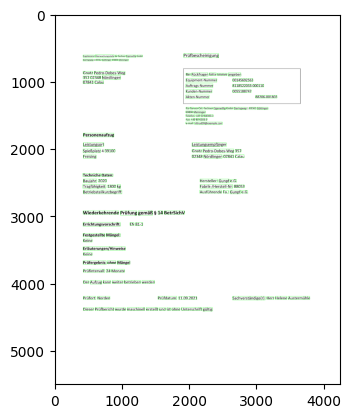

In [15]:
index = 20

image = cv2.imread(f'dataset/train/images/image_{index}.jpeg')
bbox_path = f'dataset/train/bbox/bbox_{index}.p'
with open(bbox_path, 'rb') as f:
    bbox = pickle.load(f)

def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

image = Image.fromarray(image)
width, height = image.size
print(width)
print(height)

true_boxes = [unnormalize_box(box, width, height) for idx, box in enumerate(bbox)]
image = np.array(image)
for box in true_boxes:
  box = [int(i) for i in box]
  cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
plt.imshow(image)

## Testing bboxes

In [ ]:
from dataset_creator import *

configs_train = {
    "num_files":30,
    "images_dir" : "images",
    "images_resized_dir" : "images_resized",
    "bbox_dir":"bbox",
    "input_ids_dir" : "input_ids",
    "labels_dir" : "labels",
    "entities_dir" : "entities",
    "relations_dir" : "relations",
    "type":"train",
    "clear_all_old_files" : True,
    "clear_old_files_type": [True, "validation"]
}

configs_validation = {
    "num_files":30,
    "images_dir" : "images",
    "images_resized_dir" : "images_resized",
    "bbox_dir":"bbox",
    "input_ids_dir" : "input_ids",
    "labels_dir" : "labels",
    "entities_dir" : "entities",
    "relations_dir" : "relations",
    "type":"validation",
    "clear_all_old_files" : True,
    "clear_old_files_type": [True, "validation"]
}

configs_train = {key:val for key,val in configs_train.items() if key not in ("num_files", "clear_all_old_files", "clear_old_files_type")}
configs_validation = {key:val for key,val in configs_validation.items() if key not in ("num_files", "clear_all_old_files", "clear_old_files_type")}

dataset_train = Custom_Dataset(**configs_train)
dataset_validation = Custom_Dataset(**configs_validation)

In [ ]:
sample = dataset_train[1]
image = sample['original_image']
image.shape
bbox = sample['bbox']
bbox

In [ ]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

#predictions = outputs.logits.argmax(-1).squeeze().tolist()
#token_boxes = encoding.bbox.squeeze().tolist()

image = Image.fromarray(image)
width, height = image.size
print(width)
print(height)

In [ ]:

from PIL import ImageDraw, ImageFont


draw = ImageDraw.Draw(image)

font = ImageFont.load_default()
true_boxes = [unnormalize_box(box, width, height) for idx, box in enumerate(bbox)]
#true_boxes = bbox
print(true_boxes)
def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}
image = np.array(image)
for box in true_boxes:
  #box = [int(i) for i in box]
  #cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
  #draw.text((box[0]+10, box[1]-10), fill=label2color[predicted_label], font=font)
  draw.rectangle(unnormalize_box(bbox, width=width, height=height), outline='red', width=1)


In [ ]:
plt.imshow(image)


## (Optional) Combining the real dataset with synthetic dataset

In [25]:
synthetic_dataset_dir = 'dataset/train'
real_dataset_dir = 'dataset_real/train'

In [4]:
import shutil
import os

In [21]:
sub_dirs_synth = [os.path.join(synthetic_dataset_dir, sub_dir) for sub_dir in os.listdir(synthetic_dataset_dir)]
file_names_synth = [files for files in os.listdir(sub_dirs_synth[0])]
last_known_index_synth = [int(file[file.rfind('_')+1:file.rfind('.')]) for file in file_names_synth]
last_known_index_synth = max(last_known_index_synth)
last_known_index_synth

next_index = last_known_index_synth + 1


600

In [35]:
sub_dirs_real = [sub_dir for sub_dir in os.listdir(real_dataset_dir)]

for sub_dir in sub_dirs_real:
    sub_dir_path = os.path.join(real_dataset_dir,sub_dir)
    sorted_paths = sorted(os.listdir(sub_dir_path), key=lambda x: int(x[x.rindex("_")+1:x.rindex(".")]))
    for file in sorted_paths:
        altered_file_name = f'{file[:file.rfind("_")]}_{next_index}{file[file.rfind("."):]}'
        src_path = f'{real_dataset_dir}/{sub_dir}/{file}'
        dst_path = f'{synthetic_dataset_dir}/{sub_dir}/{altered_file_name}'
        next_index += 1
        
        shutil.copy(src_path, dst_path)
    next_index = last_known_index_synth+1

    

        


dataset_real/train/labels/labels_0.p dataset/train/labels/labels_600.p
dataset_real/train/labels/labels_2.p dataset/train/labels/labels_601.p
dataset_real/train/labels/labels_3.p dataset/train/labels/labels_602.p
dataset_real/train/labels/labels_4.p dataset/train/labels/labels_603.p
dataset_real/train/labels/labels_5.p dataset/train/labels/labels_604.p
dataset_real/train/labels/labels_6.p dataset/train/labels/labels_605.p
dataset_real/train/labels/labels_8.p dataset/train/labels/labels_606.p
dataset_real/train/labels/labels_10.p dataset/train/labels/labels_607.p
dataset_real/train/labels/labels_11.p dataset/train/labels/labels_608.p
dataset_real/train/labels/labels_12.p dataset/train/labels/labels_609.p
dataset_real/train/labels/labels_13.p dataset/train/labels/labels_610.p
dataset_real/train/labels/labels_16.p dataset/train/labels/labels_611.p
dataset_real/train/labels/labels_18.p dataset/train/labels/labels_612.p
dataset_real/train/labels/labels_19.p dataset/train/labels/labels_613.p